In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import skimage.transform
from sklearn.model_selection import train_test_split
from network import neural_network

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def read_pictures(directory='train/'):
    with open('files_list.txt') as f:
        files_list = f.readlines()
    files_list = [(directory+i.strip()) for i in files_list]
    return files_list

In [3]:
input_shape = (128, 128, 1)
# files_list = read_pictures('preprocessed_images/')
files_list = read_pictures()

In [4]:
def preprocess_img(img):
    return skimage.transform.resize(img, input_shape)

In [5]:
def get_dataset(preprocess = True, files_num=1000):
    X = []
    y = []
    files_to_read = np.random.choice(files_list, files_num)
    for i in tqdm.tqdm(files_to_read):
        if preprocess:
            X.append(preprocess_img(plt.imread(i)))
        else:
            X.append(plt.imread(i))
            
        if 'cat' in i:
            y.append([1, 0])
        else:
            y.append([0, 1])
    return X, y

In [6]:
def save_preprocessed_images(images):
    for i, name in tqdm.tqdm(zip(images, files_list)):
        plt.imsave(f'preprocessed_images/{name.split("/")[-1]}', i[:,:,0])

In [7]:
X, y = get_dataset(preprocess=True, files_num=25000)

  0%|                                                                                        | 0/25000 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [05:18<00:00, 78.46it/s]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

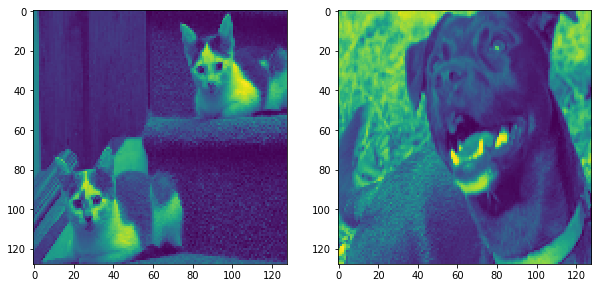

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(X[502][:,:,0]);
plt.subplot(122)
plt.imshow(X[0][:,:,0])
plt.show()

In [10]:
class cnn_network(neural_network):       
    def _inference(self):
        inp = self.input
        with tf.name_scope('classificator'):
            with tf.name_scope('convolution'):
                layer = tf.layers.conv2d(inp, 3, 1, activation=tf.nn.relu, name='deep_dreaming_input', padding='same')
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                layer = tf.layers.conv2d(inp, 32, 3, activation=tf.nn.relu)
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                layer = tf.layers.conv2d(layer, 64, 3, activation=tf.nn.relu)
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                layer = tf.nn.dropout(layer, self.dropout_prob)
                layer = tf.layers.conv2d(layer, 64, 3, activation=tf.nn.relu)
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                layer = tf.layers.conv2d(layer, 64, 3, activation=tf.nn.relu, padding='same')
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                layer = tf.layers.conv2d(layer, 32, 5, activation=tf.nn.relu, padding='same')
                layer = tf.nn.dropout(layer, self.dropout_prob)
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
    #             layer = tf.layers.conv2d(layer, 16, 5, activation=tf.nn.relu)
    #             layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                layer = tf.layers.flatten(layer)

            with tf.name_scope('dense'):
                layer = tf.layers.dense(layer, 1024, activation=tf.nn.relu)
                layer = tf.nn.dropout(layer, self.dropout_prob)
                layer = tf.layers.dense(layer, 512, activation=tf.nn.relu)
                layer = tf.layers.batch_normalization(layer)
                layer = tf.layers.dense(layer, 128, activation=tf.nn.relu)
                layer = tf.layers.batch_normalization(layer)
                layer = tf.layers.dense(layer, 2, activation=tf.nn.softmax)

        return layer

In [11]:
# if network is None:
network = cnn_network(input_shape, X_train, y_train, X_test, y_test)
network.training(batch_size=128, epochs=5, iter_before_validation=1)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Test accuracy: 68% 	Training loss: 0.6694973435472039 	 Training accuracy: 71%


 20%|████████████████▊                                                                   | 1/5 [00:08<00:34,  8.65s/it]

Test accuracy: 72% 	Training loss: 0.6032211662215343 	 Training accuracy: 77%


 40%|█████████████████████████████████▌                                                  | 2/5 [00:15<00:23,  7.94s/it]

Test accuracy: 73% 	Training loss: 0.5607206819250302 	 Training accuracy: 80%


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:23<00:15,  7.70s/it]

Test accuracy: 78% 	Training loss: 0.5415719190941138 	 Training accuracy: 82%


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:30<00:07,  7.58s/it]

Test accuracy: 79% 	Training loss: 0.524970940369017 	 Training accuracy: 85%


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:37<00:00,  7.51s/it]


In [14]:
assert len([op.name for op in tf.get_default_graph().get_operations() if 'output' in op.name or 'features' in op.name]) == 2
assert len([op.name for op in tf.get_default_graph().get_operations() if 'cnn_' in op.name]) == 0

In [15]:
network.save_model('saved_model/classifier.ckpt')